In [ ]:
%whos

In [1]:
###11.4.2024

###The notebook requires some initial input from the user
###Once this information has been filled the notebook can be run

planets = [10.57375]  ###List of the planetary periods in days
temp = 55687 ###Temperature of the star

###If you want to save arrays or values from during the run, change the respective variable to 'True'
###Given KIC number is used to name the files
KIC = 0
Transit_file = False #Writes out all the transit curves to separate files
Powerspectrum_file = False
PSsmoothed_file = False #The smoothed power spectrum
MFR_file = False
Output_file = False #dv, v_max, mass, radius, luminosity and the errors
###Fill the file destination into cell 3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import glob
import bisect
import warnings
import time as time_method
from ps import powerspectrum
from statistics import mean, stdev
#from statistics import stdev
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel

In [3]:
###Array of 0/1 to pick relevant datapoints
#Pass only 1's to consider in the next step
def pick(x,y):
    sx = x.copy() 
    sy = y.copy()
    for i in range(len(index)-1,-1,-1):
        if score[index[i]] == 0:
            sx.pop(i)
            sy.pop(i)
            index.pop(i)
    nbr_noise = 1-(len(sx))/(len(x))
    if nbr_noise > 0.05:
        print("Precentage of removed datapoints might be too high: {} with precentage {}.".format(files, nbr_noise))
    return sx, sy


###Returns one scaled array
#Creates the array of limit for each point
def poldiff(dx,dy): 
    coeff = np.polyfit(dx,dy,7)
    p = np.poly1d(coeff)
    limit = [0]*len(dy)
    for i in range(0,len(dx)):
        limit[i] = dy[i]/p(dx[i])-1
    cut = 5*np.median(np.absolute(limit))
    for i in range(0,len(dx)):
        if abs(limit[i])>=cut:
            score[index[i]]=0
    return limit
    
###Compare neighbouring points and delete if it deviates too much
#Here is assumed that polyfit has been run and the data is centered around 0
#Need to pass only the 1's, doesn't have a return value as it only alters the score
def neighbour(nx,ny): 
    lcut = 4*np.median(np.absolute(ny))
    for i in range(2,len(nx)-2):
        if math.isnan(ny[i]) == True or math.isnan(nx[i]) == True:
            print("Mistake!")
            continue
        line = np.polyfit([nx[i-2],nx[i-1],nx[i+1],nx[i+2]], [ny[i-2],ny[i-1],ny[i+1],ny[i+2]], 1)
        l = np.poly1d(line)
        
        if abs(abs(ny[i])-abs(l(nx[i]))) >= lcut:
            score[i]=0

###Delete the planetary transit
def __transit__(period, tx, ty):
    bins = int(len(tx)/500)
    if bins < 500:
        bins = 500
    for i in range(0,len(tx)):
        tx[i] = tx[i] % period
    new = pd.DataFrame({'Time mod P':tx, 'FLux':ty})
    quartiles = pd.qcut(new['Time mod P'], bins, labels=range(0,bins))
    new = new.assign(Quartile=quartiles.values)

    new_time = []
    new_flux = []
    for i in range(0,bins):
        picked = new.loc[new['Quartile'] == i]
        new_flux.append(picked.loc[:, 'FLux'].median())
        new_time.append(picked.loc[:, 'Time mod P'].median())
    return new_time, new_flux

###Locate the closest transit point to substract from the data
def find_closest(num):
    max_index = len(new_time)
    f_index = bisect.bisect(new_time, num)
    if f_index < max_index:
        if abs(new_time[f_index-1]-num) > abs(new_time[f_index]-num):
            f_index -= 1
    elif f_index == max_index:
        if abs(new_time[0]-num) > abs(new_time[max_index-1]-num):
            f_index = 0
    return f_index

###Flattening the known peaks in the data
#To be always runned after power spectrum on Power
#We want the following windows to flatten the peaks
def power_peaks(): 
    flatten_peak(3964.8,3965.5)
    flatten_peak(4531.1,4531.6)
    flatten_peak(5097.7,5098.1)
    flatten_peak(7876.2,7876.8)

###Actually flatten the peak
def flatten_peak(c,d): 
    Power_part = Power[round(c/step):round(d/step)]
    med_part = np.median(Power_part)
    while max(Power_part) > med_part:
        Power[find_peak(round(c/step),round(d/step))] -= med_part
        Power_part = Power[round(c/step):round(d/step)]
        
###Locate where the highest peak is
def find_peak(a,b):
    max_value = 0
    for j in range(a,b):
        if Power[j] > max_value:
            max_value = Power[j] 
            max_value_index = j
    return (max_value_index)

def iscorrect():
    #print(dv[max_index])
    line = np.polyfit(dv[max_index-100:max_index],smooth[max_index-100:max_index],1)
    if line[0] <= 0:
        return False
    line = np.polyfit(dv[max_index:max_index+100],smooth[max_index:max_index+100],1)
    if line[0] >= 0:
        return False
    else: 
        return True

In [4]:
#RUN THE WHOLE DATASET
files_path = r"C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\3102384"
read_files = glob.glob(os.path.join(files_path,"*.dat"))
warnings.filterwarnings("ignore") ###Gives warnings of poorly defined polynomial in the fit

#Creating the dummy arrays
time_test = []
flux_test = []
full_x = []
full_y = []

for files in read_files:
    variable_table = pd.read_csv(files, delimiter='\s+', comment='#',header=None,)
    time_test = variable_table[variable_table.columns[:1]].to_numpy()
    flux_test = variable_table[variable_table.columns[1:2]].to_numpy()
    
    lenght = len(time_test)
    fx=[0]*lenght
    fy=[0]*lenght
    score=[1]*lenght
    index = np.arange(0, lenght).tolist()
    for i in range(0,lenght): #turning df[[]] to arrays of floats
        fx[i] = float(time_test[i])
        fy[i] = float(flux_test[i])
        if np.isfinite(fy[i]) == False or math.isnan(fy[i]) == True: #Finding and removing infinities
            score[i] = 0
        if math.isnan(fy[i]) == True:
            print("Error")
    
    #For every file we correct once with polynomial and then neighboour fit
    (fx,fy) =pick(fx,fy)
    fy = poldiff(fx,fy) 
    (fx, fy) = pick(fx, fy)
    neighbour(fx,fy)
    (fx,fy) =pick(fx,fy)
    #Gathering all the files to same list
    full_x.extend(fx)
    full_y.extend(fy)
### Iterate the planetary period list
for p in range(0,len(planets)):
    changed_x = full_x.copy()
    changed_y = full_y.copy()
    (new_time,new_flux) = __transit__(planets[p],changed_x,changed_y)
#Deleting the transit
    for i in range(0,len(full_x)):
        number = changed_x[i] % planets[p]
        ind = find_closest(number)
        full_y[i] -= new_flux[ind]

    if Transit_file == True:
        dfout = pd.DataFrame({'Time':new_time, 'Flux':new_flux})
        f = open("transit_%d_%d.txt" %(KIC,p+1), 'a')
        f.write("# Transit curve of the planet with a period of {0} days \n".format(planets[p]))
        dfout.to_csv(f)
        f.close()
        del dfout

Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\3102384\kplr003102384-2012088054726_slc.dat with precentage 0.05659094343424165.
Precentage of removed datapoints might be too high: C:\Users\pars3\OneDrive - Aarhus universitet\Gradu\data\3102384\kplr003102384-2012341132017_slc.dat with precentage 0.062359697206995524.


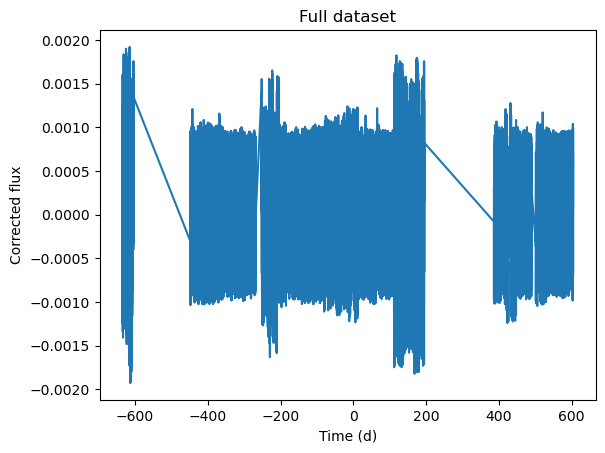

In [5]:
norm = mean(full_x)
full_x = [t - norm for t in full_x] #move around to 0
tosix = np.array(full_x) #changind into an array x
tosiy = np.array(full_y) #changing into an array y

plt.plot(full_x, full_y)
plt.xlabel('Time (d)')  
plt.ylabel('Corrected flux')
plt.title("Full dataset") 
plt.show()

psd = powerspectrum(tosix, tosiy)
Fre, Power = psd.powerspectrum(scale='powerdensity')
step = round(Fre[1]-Fre[0],8)

if Powerspectrum_file == True:
        dfout = pd.DataFrame({'Frequency':Fre, 'Power':Power})
        f = open("power_%d.txt" %(KIC), 'a')
        dfout.to_csv(f)
        f.close()
        del dfout

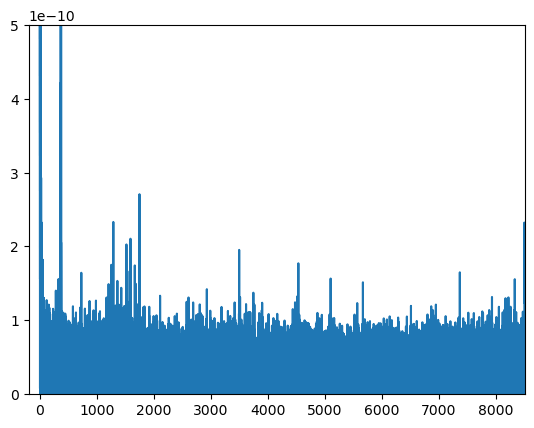

In [6]:
power_peaks()
power_peaks() #Seems to be needed twice to make it flat

plt.axis([-200, 8500, 0, 5e-10])
#plt.axis([0, 900, 0, 5e-10])
tgdata = gaussian_filter(Power, sigma=(6/step)/2.355)

if PSsmoothed_file == True:
        dfout = pd.DataFrame({'Frequency':Fre, 'Smoothed power':tgdata})
        f = open("smoothed_power_%d.txt" %(KIC), 'a')
        dfout.to_csv(f)
        f.close()
        del dfout

plt.plot(Fre, Power)

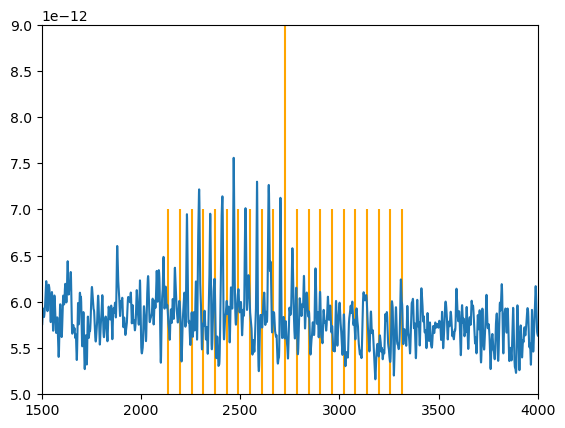

In [71]:
plt.axis([1500, 4000, 5e-12, 0.9e-11])

for m in range(-10, 11): #Taking 10 peaks from each side
    mnull = 43.9*pow((115/100),0.295)
    step = 0.5*117.9*(mnull+m+0.5)
    index_step = round(step/0.001)
    if m == 0:
        plt.vlines(x=Fre[index_step], ymin=0, ymax=9e-12, colors='orange')
    else:
        plt.vlines(x=Fre[index_step], ymin=0, ymax=7e-12, colors='orange')

plt.plot(Fre, tgdata)

In [41]:
print(Fre[2456000-1])
print(mnull)

5762.810000000001
3306.8096389530697


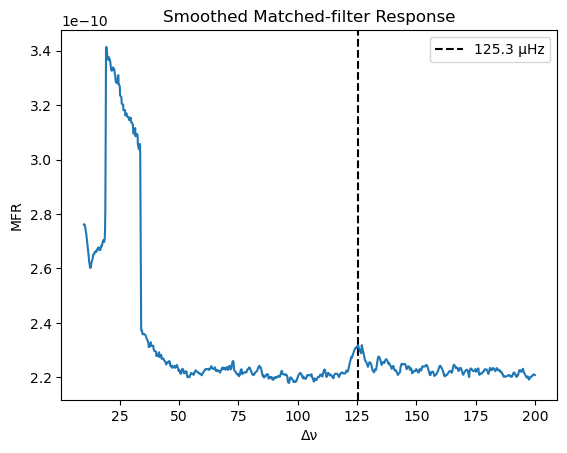

In [7]:
###MFR to find the peaks
dv = np.arange(10,200,0.1) #create delta nu array
dm = np.arange(0,1,0.001) #create delta m array
mfr = np.zeros(len(dv)) #creating array of zeros

for i in range(0, len(dv)):
    total_sum = 0
    mnull = 43.9*pow((dv[i]/100),0.295)
    for j in range(0, len(dm)):
        summa = 0
        for m in range(-10, 11): #Taking 10 peaks from each side
            step = 0.5*dv[i]*(mnull+m+dm[j])
            index_step = round(step/0.001) #Round up to the next full index
            summa += tgdata[index_step]
        if summa > total_sum: #Compare if the current value is bigger than the lastest max 
            total_sum = summa
    mfr[i] = total_sum #Save the max value per dv after varying through dm
        
smooth = gaussian_filter(mfr, sigma=1/0.1)/2.355
peak = 0
start = 200
for i in range(start, len(dv)):
    if smooth[i] >= peak:
        peak = smooth[i]
        max_index = i

if MFR_file == True:
        dfout = pd.DataFrame({'dv':dv, 'Mfr':smooth})
        f = open("mfr_%d.txt" %(KIC), 'a')
        dfout.to_csv(f)
        f.close()
        del dfout
        
while iscorrect() == False:
    peak = 0
    start += 100
    for i in range(start, len(dv)):
        if smooth[i] >= peak:
            peak = smooth[i]
            max_index = i
    if start > 1890:
        print("No significant peak found")
        break

real_nu = dv[max_index]
real_index = max_index

height = mfr[max_index] / np.mean(mfr[max_index-500:max_index+500])
if height < 1.04:
    print("The peak doesn't seem to be significant enough! The height is: ", height)


plt.axvline(x = dv[max_index], color = 'k', linestyle='dashed', label = str(round(dv[max_index],3)) + ' µHz')
plt.title('Smoothed Matched-filter Response')  
plt.ylabel('MFR')  
plt.xlabel("Δν") 
leg = plt.legend(loc='upper right')
plt.plot(dv,mfr)
plt.show()        

In [8]:
#### Calculating nu max with errors
vmax = pow((dv[max_index]/0.263),(1/0.772))
vmax_error_upper = pow((dv[max_index]/(0.263+0.009)),(1/(0.772+0.005)))
vmax_error_lower = pow((dv[max_index]/(0.263-0.009)),(1/(0.772-0.005)))

#-----

step = round(Fre[1]-Fre[0],8)
window = vmax_error_lower-vmax_error_upper


dm_peak = Power[round((vmax-window)/step):round((vmax+window)/step):10]
Fre_slice = Fre[round((vmax-window)/step):round((vmax+window)/step):10]

#smoothed_signal = convolve(dm_peak, Box1DKernel(11)) #Smooth the sliced data
#for i in range(0,132):
#    smoothed_signal = convolve(smoothed_signal, Box1DKernel(11))
sdata = gaussian_filter(dm_peak, sigma=5000) #Smooth it further

bg_coeff = np.polyfit(Fre_slice,sdata,5) #fit the background
bg_function = np.poly1d(bg_coeff)

peak = 0
for i in range(0, len(Fre_slice)):
    if bg_function(Fre_slice[i]) >= peak:
        peak = bg_function(Fre_slice[i])
        max_index = i

real_max = Fre_slice[max_index]
print("Nu_max is {}".format(Fre_slice[max_index]))

Nu_max is 3463.8300000000004


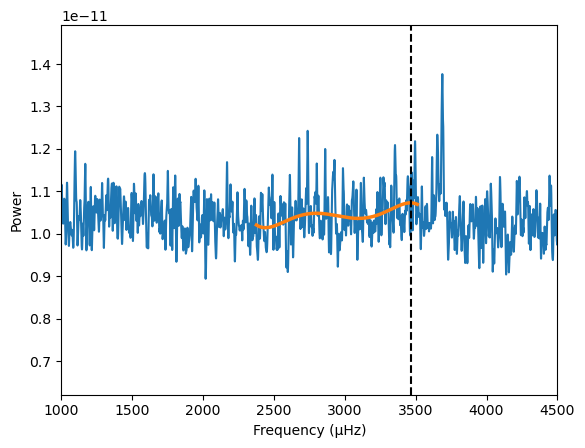

In [11]:
plt.axis([1000, 4500, 0.5*tgdata[max_index],1.2*tgdata[max_index]])
plt.plot(Fre, tgdata)
plt.plot(Fre_slice,bg_function(Fre_slice),linewidth=2.5)
plt.ylabel('Power')  
plt.xlabel("Frequency (µHz)")
plt.axvline(x = Fre_slice[max_index], color = 'k', linestyle='dashed')

In [12]:
###Creating the error bars
#HERE WE DO THROW OUT THE LAST FEW POINTS
partition = 4 ###How many values to compare fors errors
partlen = math.floor(len(full_x)/partition)
dvlist = []
vnlist = []
for k in range(0,partition):
    sliced_x = tosix[k*partlen:(k+1)*partlen]
    sliced_y = tosiy[k*partlen:(k+1)*partlen]

#--------

    psd = powerspectrum(sliced_x, sliced_y)
    Fre, Power = psd.powerspectrum(scale='powerdensity')
    step = round(Fre[1]-Fre[0],8)
    power_peaks()
    power_peaks()
    #if real_max < 2000:
        #Power_error = Power[0:round((real_max+3000)/step)]
    #else: 
        #Power_error = Power[round((real_max-2000)/step):round((real_max+2000)/step)]
    tgdata = gaussian_filter(Power, sigma=(6/0.001)/2.355)
#-------------
###MFR
    #dv = np.arange(real_index-20,real_index+20,0.1)
    dv = np.arange(real_nu-15,real_nu+15,0.1)
    dm = np.arange(0,1,0.001) 
    mfr = np.zeros(len(dv)) 

    for i in range(0, len(dv)):
        total_sum = 0
        mnull = 43.9*pow((dv[i]/100),0.295)
        for j in range(0, len(dm)):
            summa = 0
            for m in range(-10, 11): #Taking 10 peaks from each side
                step = 0.5*dv[i]*(mnull+m+dm[j])
                index_step = round(step/0.001) #Round up to the next full index
                summa += tgdata[index_step]
                #if index_step < len(tgdata):
                    #summa += tgdata[index_step]
            if summa > total_sum: #Compare if the current value is bigger than the lastest max 
                total_sum = summa
        mfr[i] = total_sum #Save the max value per dv after varying through dm

    smooth = gaussian_filter(mfr, sigma=1/0.1)/2.355
    peak = 0
    for i in range(0, len(dv)):
        if smooth[i] >= peak:
            peak = smooth[i]
            max_index = i
        
    dvlist.append(dv[max_index])

#----------------
### Find the vmax value
    vmax = pow((dv[max_index]/0.263),(1/0.772))
    vmax_error_upper = pow((dv[max_index]/(0.263+0.009)),(1/(0.772+0.005)))
    vmax_error_lower = pow((dv[max_index]/(0.263-0.009)),(1/(0.772-0.005)))

    step = round(Fre[1]-Fre[0],8)
    window = vmax_error_lower-vmax_error_upper
    
    dm_peak = Power[round((vmax-window)/step):round((vmax+window)/step):10]
    sdata = gaussian_filter(dm_peak, sigma=50000)
    Fre_slice = Fre[round((vmax-window)/step):round((vmax+window)/step):10]

    smoothed_signal = convolve(dm_peak, Box1DKernel(11))
    for i in range(0,132):
        smoothed_signal = convolve(smoothed_signal, Box1DKernel(11))
    sdata = gaussian_filter(dm_peak, sigma=5000)

    bg_coeff = np.polyfit(Fre_slice,sdata,5) 
    bg_function = np.poly1d(bg_coeff)
    peak = 0
    for i in range(0, len(Fre_slice)):
        if bg_function(Fre_slice[i]) >= peak:
            peak = bg_function(Fre_slice[i])
            max_index = i
    vnlist.append(Fre_slice[max_index])
   

print("The error of delta nu is: " ,stdev(dvlist)/math.sqrt(len(dvlist)))
print("And for nu max: " ,stdev(vnlist)/math.sqrt(len(vnlist)))

print("The delta nu array: " ,dvlist)
print("The nu max array: " ,vnlist)

The error of delta nu is:  7.0852399394794165
And for nu max:  174.25837849297233
The delta nu array:  [140.19999999999789, 110.29999999999959, 126.19999999999868, 111.19999999999953]
The nu max array:  [3592.9950000000003, 2849.2450000000003, 3421.8849999999998, 3002.995]


In [24]:
mass = (real_max/3100)**3*(real_nu/134.8)**(-4)*(temp/5772)**(1.5)
radius = (real_max/3100)*(real_nu/134.8)**(-2)*(temp/5772)**(0.5)
luminosity = radius**2*(temp/5772)**4

max_error = stdev(vnlist)/math.sqrt(len(vnlist))
nu_error = stdev(dvlist)/math.sqrt(len(dvlist))

mass_upper = ((real_max+max_error)/3100)**3*((real_nu-nu_error)/134.8)**(-4)*(temp/5772)**(1.5)-mass
radius_upper = ((real_max+max_error)/3100)*((real_nu-nu_error)/134.8)**(-2)*(temp/5772)**(0.5)-radius
luminosity_upper = (radius+radius_upper)**2*(temp/5772)**4-luminosity

mass_lower = mass-((real_max-max_error)/3100)**3*((real_nu+nu_error)/134.8)**(-4)*(temp/5772)**(1.5)
radius_lower = radius-((real_max-max_error)/3100)*((real_nu+nu_error)/134.8)**(-2)*(temp/5772)**(0.5)
luminosity_lower = luminosity-(radius-radius_lower)**2*(temp/5772)**4


print("The mass is {} with error of +{} and -{}".format(mass, mass_upper, mass_lower))
print("The radius is {} with error of +{} and -{}".format(radius, radius_upper, radius_lower))
print("The luminosity is {} with error of +{} and -{}".format(luminosity, luminosity_upper, luminosity_lower))

if Output_file == True:
        f = open("Out_%d.txt" %(KIC), 'a')
        f.write("Delta nu is {} with the error of {} \n".format(real_nu,nu_error))
        f.write("Nu max is {} with the error of {} \n".format(real_max,max_error))
        f.write("The mass is {} with error of +{} and -{} \n".format(mass, mass_upper, mass_lower))
        f.write("The radius is {} with error of +{} and -{} \n".format(radius, radius_upper, radius_lower))
        f.write("The luminosity is {} with error of +{} and -{}".format(luminosity, luminosity_upper, luminosity_lower))
        f.close()

The mass is 0.9957670705580959 with error of +0.5109412469465244 and -0.3439100129237481
The radius is 1.5339940547757562 with error of +0.2837261920718621 and -0.24168768144605846
The luminosity is 2.754893393035451 with error of +1.1133298837792904 and -0.7997058709606775
